In [3]:
!pip install pillow
!pip uninstall -y cupy cupy-cuda11x cupy-cuda12x

Found existing installation: cupy-cuda11x 13.6.0
Uninstalling cupy-cuda11x-13.6.0:
  Successfully uninstalled cupy-cuda11x-13.6.0
Found existing installation: cupy-cuda12x 13.3.0
Uninstalling cupy-cuda12x-13.3.0:
  Successfully uninstalled cupy-cuda12x-13.3.0


In [1]:
!pip install cupy-cuda12x

In [2]:
import cupy as cp
print(cp.__version__)
x = cp.ones((2,2))
print(x)

13.6.0
[[1. 1.]
 [1. 1.]]


$ nvidia-smi --query-gpu=driver_version,cuda_version --format=csv,noheader,nounits || true
Field "cuda_version" is not a valid field to query.


Detected CUDA version: None
Trying to install cupy-cuda11x ...
$ /usr/bin/python3 -m pip install -q cupy-cuda11x

CuPy import succeeded.
cupy version: 13.6.0


Saving example.png to example (1).png
Uploaded: example (1).png


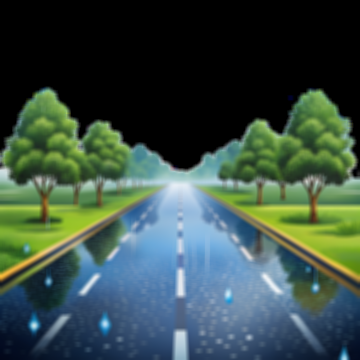

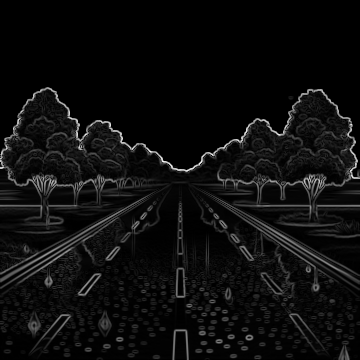

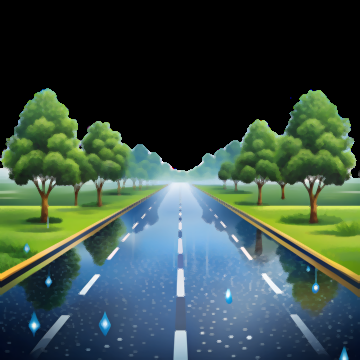

Saved files: result_blur.png result_edges.png result_median.png


In [3]:
import subprocess
import sys
import re
import os
import time
import numpy as np
from PIL import Image
from IPython.display import display
from google.colab import files, drive

def run(cmd):
    """
    Выполняет команду cmd в терминале и выводит её результат.
    Возвращает кортеж (код возврата, stdout).
    """
    print("$", cmd)  # печать команды
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    print(p.stdout)  # вывод результата команды
    return p.returncode, p.stdout

rc, out = run("nvidia-smi --query-gpu=driver_version,cuda_version --format=csv,noheader,nounits || true")

cuda_ver = None
# Ищем версию CUDA в выводе команды nvidia-smi
m = re.search(r'(\d+\.\d+)', out)
if m:
    cuda_ver = m.group(1)
print("Detected CUDA version:", cuda_ver)

# Определение подходящих пакетов CuPy для установки
candidates = []
if cuda_ver:
    major = int(cuda_ver.split(".")[0])
    if major >= 12:
        candidates = ["cupy-cuda12x", "cupy"]
    elif major >= 11:
        candidates = ["cupy-cuda11x", "cupy"]
    else:
        candidates = ["cupy"]
else:
    # если CUDA не обнаружена, попробуем несколько вариантов
    candidates = ["cupy-cuda11x", "cupy-cuda12x", "cupy"]

# Попытка установки CuPy
installed = False
for pkg in candidates:
    print(f"Trying to install {pkg} ...")
    rc, out = run(f"{sys.executable} -m pip install -q {pkg}")
    if rc == 0:
        try:
            __import__("cupy")  # проверяем импорт
            print("CuPy import succeeded.")
            installed = True
            break
        except Exception as e:
            print("CuPy import failed:", e)
    else:
        print(f"pip install exit code {rc}")

if not installed:
    print("Falling back to CPU-only SciPy implementation.")
    run(f"{sys.executable} -m pip install -q scipy")
else:
    import cupy as cp
    print("cupy version:", cp.__version__)

# Загрузка изображения из локального компьютера в Colab
uploaded = files.upload()  # диалоговое окно для выбора файла
fn = next(iter(uploaded.keys()))  # имя первого загруженного файла
print("Uploaded:", fn)

# Выбор между GPU (CuPy) и CPU (NumPy + SciPy)
try:
    import cupy as cp
    import cupyx.scipy.ndimage as cnd_gpu  # GPU версии функций SciPy
    USE_CUPY = True
except Exception:
    from scipy import ndimage as cnd_cpu   # CPU версии
    USE_CUPY = False

if USE_CUPY:
    xp = cp  # xp будет ссылаться на CuPy для работы с GPU
    nd = cnd_gpu
    # функции для перевода данных на GPU и обратно
    def to_device(a): return cp.asarray(a, dtype=cp.float32)
    def to_host(a): return cp.asnumpy(a)
    def sync(): cp.cuda.Stream.null.synchronize()  # синхронизация GPU
else:
    xp = np  # NumPy для CPU
    nd = cnd_cpu
    def to_device(a): return a.astype(np.float32)
    def to_host(a): return a
    def sync(): None  # нет необходимости синхронизировать CPU

# Функции для работы с изображениями
def load_image(path):
    """Загрузка изображения и нормализация пикселей к [0,1]"""
    img = Image.open(path).convert('RGB')
    return np.asarray(img, dtype=np.float32) / 255.0

def save_image_float01(arr, path):
    """Сохранение изображения с float [0,1] в PNG"""
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    Image.fromarray(arr).save(path, format='PNG')

# Фильтры обработки изображений
def box_blur(img_xp, kernel_size=5):
    """Простое размытие изображения с помощью усредняющего ядра"""
    k = kernel_size
    kernel = xp.ones((k,k), dtype=xp.float32) / (k*k)
    out = xp.empty_like(img_xp)
    for c in range(img_xp.shape[2]):
        out[..., c] = nd.convolve(img_xp[..., c], kernel, mode='mirror')
    return out

def sobel_edge(img_xp):
    """Детекция границ с помощью фильтров Собеля"""
    kx = xp.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=xp.float32)
    ky = xp.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=xp.float32)
    # перевод в оттенки серого
    gray = 0.2989 * img_xp[...,0] + 0.5870 * img_xp[...,1] + 0.1140 * img_xp[...,2]
    gx = nd.convolve(gray, kx, mode='mirror')
    gy = nd.convolve(gray, ky, mode='mirror')
    mag = xp.sqrt(gx*gx + gy*gy)  # вычисляем градиент
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-12)  # нормализация
    return xp.stack([mag, mag, mag], axis=-1)  # возвращаем RGB изображение

def median_denoise(img_xp, size=3):
    """Медианный фильтр для шумоподавления"""
    out = xp.empty_like(img_xp)
    for c in range(img_xp.shape[2]):
        out[..., c] = nd.median_filter(img_xp[..., c], size=size, mode='mirror')
    return out

# Основной код обработки изображения
INPUT = fn        # имя входного файла
PREFIX = "result" # префикс для сохранения результатов

# Загрузка изображения и отправка на устройство (GPU или CPU)
arr = load_image(INPUT)
img_dev = to_device(arr)
sync()

# 1. Применяем размытие
blurred = box_blur(img_dev, kernel_size=5)
out_blur = to_host(blurred)
save_image_float01(out_blur, PREFIX + "_blur.png")
display(Image.open(PREFIX + "_blur.png"))

# 2. Детекция границ
edges = sobel_edge(img_dev)
out_edges = to_host(edges)
save_image_float01(out_edges, PREFIX + "_edges.png")
display(Image.open(PREFIX + "_edges.png"))

# 3. Медианное шумоподавление
denoised = median_denoise(img_dev, size=3)
out_med = to_host(denoised)
save_image_float01(out_med, PREFIX + "_median.png")
display(Image.open(PREFIX + "_median.png"))

print("Saved files:", PREFIX + "_blur.png", PREFIX + "_edges.png", PREFIX + "_median.png")
